In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.layers import Activation, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from pprint import pprint
from pylab import *
#from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve 
from sklearn.preprocessing import StandardScaler

import model_utils as util

sys.path.append('../')
import data_manipulations as manip

%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 8
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
DATA_PATH =  '../../data/cluster/internal/'
os.listdir(DATA_PATH)

['weights.bestNN.hdf5',
 'X_test.csv',
 'X_train.csv',
 'X_valid.csv',
 'y_test.csv',
 'y_test.csv~',
 'y_train.csv',
 'y_train.csv~',
 'y_valid.csv',
 'y_valid.csv~']

In [3]:
[[X_train, y_train], 
 [X_valid, y_valid], 
 [X_test, y_test]] = util.load_data(DATA_PATH)

X_train: (588570, 24)
X_valid: (147915, 24)
X_test: (146220, 24)
y_train: (588570, 1)
y_valid: (147915, 1)
y_test: (146220, 1)


In [4]:
y_train.head()

,beetle
0,0
1,0
2,0
3,0
4,0


In [5]:
def print_percent_presence(y, y_name):
    print('Percent presence in %s: %.2f%%' % 
          (y_name, 100 * y.sum() / y.shape[0]))

In [6]:
print_percent_presence(y_train, 'y_train')
print_percent_presence(y_valid, 'y_valid')
print_percent_presence(y_test,  'y_test')

Percent presence in y_train: 8.90%
Percent presence in y_valid: 18.76%
Percent presence in y_test: 39.75%


In [7]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'year'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'year'], axis=1)
X_test  = X_test.drop(['studyArea', 'x', 'y', 'year'],  axis=1)

In [8]:
np.isfinite(X_train).all()

meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
elev_srtm30                 True
dtype: bool

In [9]:
print('X_train:', 
      np.isnan(X_train.varPrecip_growingSeason).sum() / X_train.shape[0])
print('X_valid:', 
      np.isnan(X_valid.varPrecip_growingSeason).sum() / X_valid.shape[0])
print('X_test:',  
      np.isnan(X_test.varPrecip_growingSeason).sum() / X_test.shape[0])

X_train: 0.0072803574766
X_valid: 6.08457560085e-05
X_test: 0.0


In [10]:
X_train, y_train = util.drop_nans(
    X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = util.drop_nans(
    X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = util.drop_nans(
    X_test,  y_test,  'varPrecip_growingSeason')

(584285, 20) (584285, 1)
(147906, 20) (147906, 1)
(146220, 20) (146220, 1)


In [11]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [12]:
y_train = util.vectorize(y_train.as_matrix())
y_valid = util.vectorize(y_valid.as_matrix())
y_test  = util.vectorize(y_test.as_matrix())

In [13]:
best_val_loss = np.inf
X_train.shape

(584285, 20)

In [14]:
# Params and Hyperparams
n_inputs = X_train.shape[1]
n_outputs = 2

# Current best
N_LAYERS = 8
NODES_PER_LAYER = ([n_inputs] * N_LAYERS)
#NODES_PER_LAYER = [
#    n_inputs, n_inputs * 2, n_inputs * 4, n_inputs * 4, n_inputs *2, 
#    n_inputs]
NODES_PER_LAYER.append(n_outputs)
ETA = 0.01
DROPOUT = 0.4
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
DECAY = 0.01
EPOCHS = 124
BATCH_SIZE = 1024

NODES_PER_LAYER

[20, 20, 20, 20, 20, 20, 20, 20, 2]

In [15]:
def get_params():
    return {'NODES_PER_LAYER': NODES_PER_LAYER,
            'ETA': ETA,
            'DROPOUT': DROPOUT,
            'BETA_1': BETA_1,
            'BETA_2': BETA_2,
            'EPSILON': EPSILON,
            'DECAY': DECAY,
            'EPOCHS': EPOCHS,
            'BATCH_SIZE': BATCH_SIZE}

In [16]:
model = Sequential()

# NOTE: "glorot-normal" is the same thing as "Xavier" initialization
model.add(Dense(NODES_PER_LAYER[1], 
                input_dim=NODES_PER_LAYER[0], 
                kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

# additional hidden layers here
for i in range(2, len(NODES_PER_LAYER) - 1):
    model.add(Dense(NODES_PER_LAYER[i], 
                    kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))

model.add(Dense(NODES_PER_LAYER[-1], kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
__________

In [17]:
adam = Adam(
    lr=ETA, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=DECAY)
model.compile(
    loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [18]:
VERBOSE = 1
checkpointer = ModelCheckpoint(filepath=DATA_PATH + 'weights.bestNN.hdf5',
                               verbose=VERBOSE,
                               save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=50)
start = time.time()
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpointer, earlyStop],
                    verbose=VERBOSE)
elapsed = time.time() - start

Train on 584285 samples, validate on 147906 samples
Epoch 1/124
584285/584285 [==============================] - 18s 31us/step - loss: 0.3093 - acc: 0.9013 - val_loss: 0.4037 - val_acc: 0.8124
Epoch 2/124
584285/584285 [==============================] - 16s 27us/step - loss: 0.2251 - acc: 0.9066 - val_loss: 0.3997 - val_acc: 0.8124
Epoch 3/124
584285/584285 [==============================] - 15s 25us/step - loss: 0.2133 - acc: 0.9077 - val_loss: 0.3967 - val_acc: 0.8124
Epoch 4/124
584285/584285 [==============================] - 16s 28us/step - loss: 0.2076 - acc: 0.9085 - val_loss: 0.3987 - val_acc: 0.8124
Epoch 5/124
584285/584285 [==============================] - 16s 27us/step - loss: 0.2042 - acc: 0.9088 - val_loss: 0.3963 - val_acc: 0.8124
Epoch 6/124
584285/584285 [==============================] - 15s 26us/step - loss: 0.2021 - acc: 0.9083 - val_loss: 0.3905 - val_acc: 0.8124
Epoch 7/124
584285/584285 [==============================] - 16s 27us/step - loss: 0.1998 - acc: 0.909

In [19]:
print('Time: %.2f minutes' % (elapsed / 60))

Time: 14.33 minutes


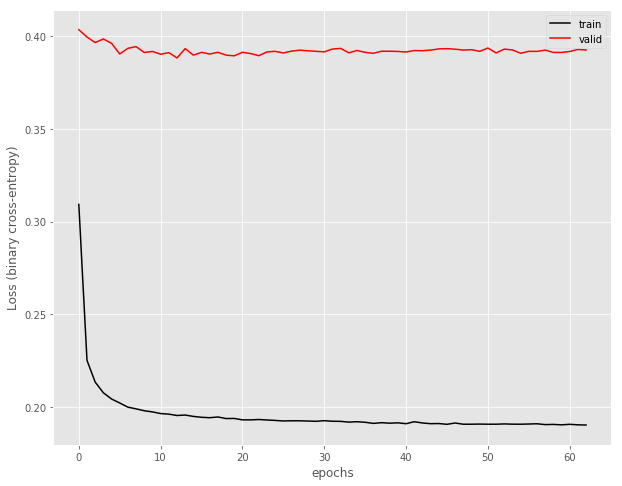

In [20]:
plt.plot(history.history['loss'], 'k-', label='train');
plt.plot(history.history['val_loss'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Loss (binary cross-entropy)')
#plt.yscale('log');
plt.legend(loc='best');

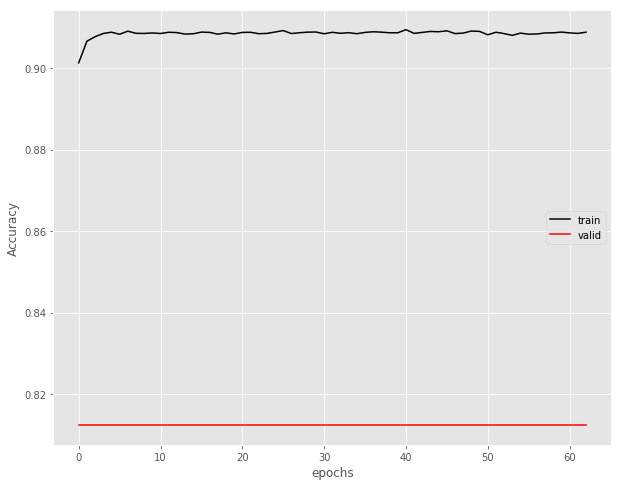

In [21]:
plt.plot(history.history['acc'], 'k-', label='train');
plt.plot(history.history['val_acc'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Accuracy')
#plt.yscale('log');
plt.legend(loc='best');

In [22]:
this_run = np.mean(history.history['val_loss'][-50:])
print('This run: %.5f' % this_run)

This run: 0.39195


In [23]:
if this_run < best_val_loss:
    print('New Best Model Found!\n')
    best_val_loss = this_run
    train_loss_of_best = np.mean(history.history['loss'][-50:])
    best_params = get_params()
print('Best validation loss so far: %.5f' % best_val_loss)
print('Training loss of same model: %.5f' % train_loss_of_best)
print('Best hyperparameters found so far:')
pprint(best_params)

New Best Model Found!

Best validation loss so far: 0.39195
Training loss of same model: 0.19180
Best hyperparameters found so far:
{'BATCH_SIZE': 1024,
 'BETA_1': 0.9,
 'BETA_2': 0.999,
 'DECAY': 0.01,
 'DROPOUT': 0.4,
 'EPOCHS': 124,
 'EPSILON': 1e-08,
 'ETA': 0.01,
 'NODES_PER_LAYER': [20, 20, 20, 20, 20, 20, 20, 20, 2]}


In [24]:
preds = model.predict(X_test)

In [25]:
pred_probs = util.preds2probs(preds)

In [26]:
preds = util.one_cold(util.binarize(preds))
y_test = util.one_cold((y_test))

In [27]:
cm = util.make_confusion_matrix(y_test, pred_probs, 0.5)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	0		58122
        0	0		88098


In [28]:
metrics = util.get_metrics(cm)

Accuracy:  0.602503077554
Precision: nan
Recall:    0.0
F1:        nan


/Users/dsp/dongmei/sdm/python/models/model_utils.py:105: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm['tp'] / (cm['tp'] + cm['fp'])


In [29]:
auc_metrics = util.get_auc(y_test, pred_probs)

AUC:       0.817030452792


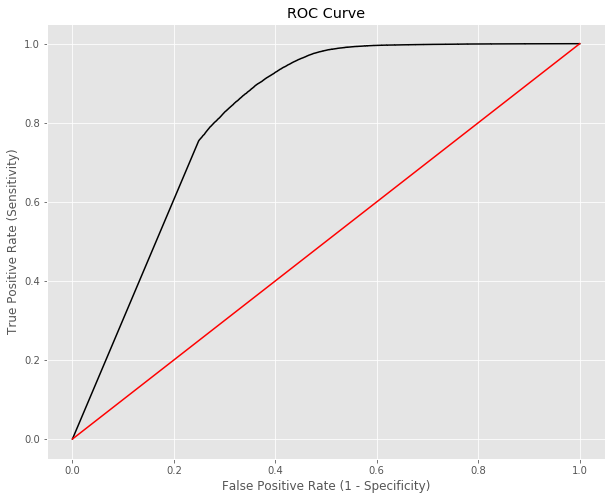

In [30]:
util.plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])